In [3]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [29]:
home_dir = os.path.abspath('..')
iteration = '4'

In [81]:
def prepare_data(stocks_dir, sentiments_dir, window_size=60):
    stock_files = os.listdir(stocks_dir)
    sentiment_files = os.listdir(sentiments_dir)

    X = []
    y = []

    for f in stock_files:
        if f in sentiment_files:
            stock_df = pd.read_csv(f"{stocks_dir}\\{f}")
            sentiment_df = pd.read_csv(f"{sentiments_dir}\\{f}")

            combined_df = pd.merge(stock_df, sentiment_df, left_on='fdate', right_on='formatted_date', how='outer')

            combined_df['fdate'] = pd.to_datetime(combined_df['fdate'].combine_first(combined_df['formatted_date']))
            combined_df = combined_df.drop(columns=['formatted_date', 'Date', 'Dividends', 'Stock Splits', 'Volume']).dropna()

            combined_df = combined_df.sort_values(by='fdate')
            for i in range(0, (len(combined_df) - window_size - 7), 3):
                # Prepare 60-day stock data
                open_data = combined_df['Open'].values[i:i+60]
                high_data = combined_df['High'].values[i:i+60]
                low_data = combined_df['Low'].values[i:i+60]
                close_data = combined_df['Close'].values[i:i+60]

                nopen_data = open_data / np.max(open_data)
                nhigh_data = high_data / np.max(high_data)
                nlow_data = low_data / np.max(low_data)
                nclose_data = close_data / np.max(close_data)

                # num_articles_data = combined_df['articles'].values[i:i+60]
                # sentiment_data = combined_df['sentiment'].values[i:i+60]/combined_df['articles'].values[i:i+60]

                # Prepare 7-day article and sentiment data, padded with 53 zeros on the left
                num_articles_data = np.pad(combined_df['articles'].values[i+53:i+60], (53, 0), 'constant')
                sentiment_data = np.pad(combined_df['sentiment'].values[i+53:i+60]/combined_df['articles'].values[i+53:i+60], (53, 0), 'constant')

                # Output: 7-day future high and low values
                noutput_high = combined_df['High'].values[i+60:i+67] / (np.max(high_data))
                noutput_low = combined_df['Low'].values[i+60:i+67] / (np.max(low_data))

                output_high = combined_df['High'].values[i+60:i+67]
                output_low = combined_df['Low'].values[i+60:i+67]

                # Stack inputs into the desired shape (60, 5) for stock data and (60, 2) for articles & sentiment
                input_data = [
                    open_data, high_data, low_data, close_data, nopen_data, nhigh_data, nlow_data, nclose_data, num_articles_data, sentiment_data
                ]

                if np.greater(open_data, [0]).all() and np.greater(high_data, [0]).all() and np.greater(low_data, [0]).all() and np.greater(close_data, [0]).all() and np.greater(output_high, [0]).all() and np.greater(output_low, [0]).all():
                    X.append(np.array(input_data))
                    y.append(np.array([output_high, output_low, noutput_high, noutput_low]))
    
    return np.array(X), np.array(y)

In [77]:
stocks_dir = f"{home_dir}\\data\\cleaned_data\\stock_data"
sentiments_dir = f"{home_dir}\\data\\cleaned_data\\sentiment_data"

X, y = prepare_data(stocks_dir, sentiments_dir)

print(X.shape, y.shape)
print(type(X))

(62631, 10, 60) (62631, 4, 7)
<class 'numpy.ndarray'>


In [19]:
print(X[:,4:,:].shape, y[:,2:,:].shape)

(62631, 6, 60) (62631, 2, 7)


In [78]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 50104
Validation set size: 6263
Test set size: 6264


In [79]:
y_train = y_train.reshape(-1, 28)  # Reshape to (num_samples, 14)

y_val = y_val.reshape(-1, 28)

y_test = y_test.reshape(-1, 28)

print(X_train.shape, y_train.shape)

(50104, 10, 60) (50104, 28)


In [80]:
os.makedirs(f'{home_dir}\\data\\processed_data\\training_{iteration}', exist_ok=True)

np.save(f'{home_dir}\\data\\processed_data\\training_{iteration}\\X_train.npy', X_train)
np.save(f'{home_dir}\\data\\processed_data\\training_{iteration}\\y_train.npy', y_train)

np.save(f'{home_dir}\\data\\processed_data\\training_{iteration}\\X_val.npy', X_val)
np.save(f'{home_dir}\\data\\processed_data\\training_{iteration}\\y_val.npy', y_val)

np.save(f'{home_dir}\\data\\processed_data\\training_{iteration}\\X_test.npy', X_test)
np.save(f'{home_dir}\\data\\processed_data\\training_{iteration}\\y_test.npy', y_test)

In [30]:
X_train = np.load(f'{home_dir}\\data\\processed_data\\training_{iteration}\\X_train.npy')
y_train = np.load(f'{home_dir}\\data\\processed_data\\training_{iteration}\\y_train.npy')

X_val = np.load(f'{home_dir}\\data\\processed_data\\training_{iteration}\\X_val.npy')
y_val = np.load(f'{home_dir}\\data\\processed_data\\training_{iteration}\\y_val.npy')

X_test = np.load(f'{home_dir}\\data\\processed_data\\training_{iteration}\\X_test.npy')
y_test = np.load(f'{home_dir}\\data\\processed_data\\training_{iteration}\\y_test.npy')

In [82]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=regularizers.l2(0.001))),
        tf.keras.layers.Dense(14, activation='relu'),  # Output layer with 14 neurons
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [9]:
print(X_train.shape, y_train.shape)
print(X_train[:,4:,:].shape, y_train[:,14:].shape)

(50104, 10, 60) (50104, 28)
(50104, 6, 60) (50104, 14)


In [83]:
# Checkpoint system
checkpoint_path = os.path.join(home_dir, "model_checkpoints", f"training_{iteration}", "cp-{epoch:04d}.weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)

os.makedirs(checkpoint_dir, exist_ok=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_weights_only=True, verbose=1
)

input_shape = (6, 60)
model = create_model(input_shape)

model.summary()
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print()

# Train the model with the checkpoint callback
history = model.fit(X_train[:,4:,:], y_train[:,14:], validation_data=(X_val[:,4:,:], y_val[:,14:]), epochs=50, batch_size=16, callbacks=[cp_callback])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_27                │ (None, 6, 128)         │        64,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 6, 64)          │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,958 (511.55 KB)

 Trainable params: 130,958 (511.55 KB)

 Non-trainable params: 0 (0.00 B)

<class 'numpy.ndarray'> (50104, 10, 60)
<class 'numpy.ndarray'> (50104, 28)

Epoch 1/50
3128/3132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1588
Epoch 1: saving model to c:\Users\Matthew\Desktop\Projects\StockPredictor\model_checkpoints\training_4\cp-0001.weights.h5
3132/3132 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.1586 - val_loss: 0.0066
Epoch 2/50
3131/3132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068
Epoch 2: saving model to c:\Users\Matthew\Desktop\Projects\StockPredictor\model_checkpoints\training_4\cp-0002.weights.h5
3132/3132 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 3/50
3126/3132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 3: saving model to c:\Users\Matthew\Desktop\Projects\StockPredictor\model_checkpoints\training_4\cp-0003.weights.h5
3132/3132 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 4/50
3132/3132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 4: saving model to c:\Users\Matthew\Deskt

In [35]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

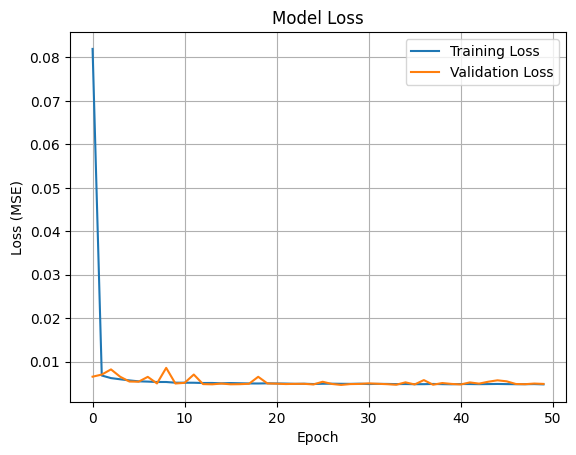

In [84]:
plot_loss(history)

In [85]:
model_directory = os.path.join(home_dir, "saved_models")
model_name = f"model_{iteration}.keras"

os.makedirs(model_directory, exist_ok=True)

model.save(os.path.join(model_directory, model_name))